### 0. Contents.

- Introduction
- Data preparation and description
- Analysis

### 1. Introduction

In this paper we attempt to extend work in our two earlier papers [add ref].  These papers both dealt with the problems of:
- What is the correct framework for the modelling problem faced in drug discovery?  In particular, how should the in and out-of-sample datasets be selected?
- How should we choose which machine learning algorithm should be chosen to tackle the prediction problem?

These two papers both used the same datasets extracted from Chembl of activity levels of compounds against 25 different targets, with the datasets associated to each target being distinct, and comprising between 300 (smallest) and 5000 (largest) points.

In this paper we deal with two datasets - entirely distinct from that used above. We use a 'big dataset' of roughly 7.5M molecules available from Molport.  We also use the (to our knowledge) largest single target dataset available within Chembl, namely the malaria dataset.

Our ealier papers operated with the following assumption.  Given a dataset with activity against some target (e.g. our HERG dataset of around 5000 compound activities from Chembl against the HERG target), this was the _only information_ we had about compound activity against HERG.

This assumption is certainly false.  In this paper, we use a different - probably false - assumption; in fact _the opposite_ assumption from our first two papers.  Namely we assume that _every known compound not in a dataset associated to a given target is inactive against that target_.

This assumption poses some challenges not encountered in our ealier work - in particular computation challenges of dealing with big datasets (since there are many known compounds).  We examine these, in the context of finding potent and high-lipophyic molecules in an out-of-sample dataset.

Finally - as an item of curiosity, we look at which molecules available via Molport are predicted to be active drugs against malaria.


### 2. Data preparation and description.

We use two datasets in this research.

1) The (slightly under) 7.5M compounds available for purchase from Molport https://www.molport.com/shop/index.

2) The (roughly 20K+) hits against _Plasmodium Falciparum_ from the GSK+Chembl full dataset, available here: https://chembl.gitbook.io/chembl-ntd/downloads/deposited-set-1-gsk-tcams-dataset-20th-may-2010.  The provenence of this data his described here:
https://www.mmv.org/research-development/open-source-research/open-access-malaria-box/malaria-box-supporting-information. In particular, we use the chembl field: pXC50_3D7 - which we map to the 'CHEMBL EC50 in µM (against P. falciparum 3D7, as reported in the ChEMBL database', and 'ALOGP' which we use to model the "Greasiness",

To both datasets we associate canonical smiles as calculated by our own standardiser software, to ensure uniqueness.  From these canonical smiles we then separately calculate 128 bit _binary fingerprints_ and 128 bit _hashed fingerprints_.  These will be the predictors used in the subsequent analysis.

### 3. Analysis.

In this section we start the analysis of our two datasets.

3.0. Quick recap of Malaria drug highlights.
- Artemisinin                       https://pubchem.ncbi.nlm.nih.gov/compound/artemisinin
- Atovaquone/Proguanil (Malarone)   https://pubchem.ncbi.nlm.nih.gov/compound/atovaquone
- Chloroquine.                      https://pubchem.ncbi.nlm.nih.gov/compound/chloroquine
- Doxycycline.                      https://pubchem.ncbi.nlm.nih.gov/compound/doxycycline
- Mefloquine (Lariam)               https://pubchem.ncbi.nlm.nih.gov/compound/Lariam
- Primaquine.                       https://pubchem.ncbi.nlm.nih.gov/compound/primaquine

Basic data sanity checks.

3.1.  Hashed vs. Non-hashed fingerprints.
- Performance of hashed vs. non-hashed fingerprints.

3.2.  Lipophylicity
- Two ways of doing prediction
- Comparison with potency
- Using Lipophylicity and potency to cluster.

3.3. The challenge of large datasets.
- Intro: fitting models on large datasets.
- Sensitivity to subsample size.
- Sensitivity to number of estimators.
- Sensitivity to 'default potency'.
- Quantile bootstrap results: binning on potency.
- Quantile bootstrap results: binning on Lipophylicity.

3.4. Analysis of QED as a predictor.

3.5. Molport suggestions.
- Potency
- Lipophylicity


TODO (next):
    - write up
    - remove code
    
TODO (later)
    - all the stuff on large datasets and James objective...
    - look at how to specify 'base knowlegdge' via a RF, fit linear model
    on 'unexpected' stuff, see if that generalizes better (how to test?)
    - related to that, need to think about clustering more...
    - look at what you end up choosing from Molport if you say that everything not in Chembl is rubbish...
    (and check that in these cases, you get stuff with smaller avg tani distance from Chembl)
   

In [514]:
from IPython.display import HTML

In [515]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### To do...

#### Data prep
- can we load all Molport data into memory at once?
- let's make sure we have fingerprints saved properly

In [227]:
from __future__ import division, print_function

In [1]:
import glob
raw_files = glob.glob('/Users/oliverwatson/evartech/molport/iissc*')

In [2]:
import numpy as np
import pandas as pd

In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from scipy import stats
import joblib
from rdkit.Chem import AllChem

In [5]:
from standardiser import standardise

In [17]:
def get_isidro_smile(x):
    try:
        return standardise.run(x)
    except:
        return 'None'

In [7]:
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

In [147]:
def get_fp(sm, logfail=False, hashed=False):
    try:
        if hashed:
            fp = np.array(list(GetHashedMorganFingerprint(Chem.MolFromSmiles(sm),2,nBits=128)), dtype=np.uint16)
        else:
            fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm),2,nBits=128) 
    except:
        if logfail:
            print("Cannot extract Mol from %s" % sm)
            pass
        if hashed:
            fp = np.zeros(128, dtype=np.uint16)
        else:
            fp = np.zeros(128, dtype=bool)
            pass
        pass
    return fp

In [13]:
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

In [14]:
import os.path

In [16]:
for (i, fn) in enumerate(raw_files):
    sfn = '/Users/oliverwatson/evartech/molport/standardn_' + str(i)
    if os.path.isfile(sfn):
        continue
    print('Doing', fn)
    df1 = pd.read_csv(fn, low_memory=False, sep='\t')
    df1['SMILESIS'] = pd.Series([get_isidro_smile(x) for x in df1.SMILES_CANONICAL.values])
    # Construct fingerprints from ISIDRO smiles (so we don't eg have salts)
    fps = [get_fp(x) for x in df1.SMILESIS.values]
    df1['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=df1.index)
    hfps = [get_fp(x, hashed=True) for x in df1.SMILESIS.values]
    df1['hfps'] = pd.Series([np.asarray(fp).astype(bool) for fp in hfps], index=df1.index)
    df1.to_pickle(sfn)

In [516]:
# Fix the hashed fingerprints...
#for (i, fn) in enumerate(raw_files):
#    sfn = '/Users/oliverwatson/evartech/molport/standardn_' + str(i)
#    df1 = pd.read_pickle(sfn)
#    hfps = [get_fp(x, hashed=True) for x in df1.SMILESIS.values]
#    df1['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=df1.index)
#    df1.to_pickle(sfn)

### Adding the 'predictable' dataset...

We're going to need some actual data with 'non-zero' values to add to this.  We'd really like the largest dataset possible, so we'll take the entirety of the Chembl malaria dataset (how exactly this differs from plasmodium f. as a target I am unsure...)

Then we're going to estimate three averages...
- the average distance between two random points in the Malaria dataset.
- the average distance between two random points in the Molport dataset
- the average distance between a point in Malaria and a point in Molport

Those last two should be (I think) almost identical.  Of course - it may not matter what the mean distance is, may really be a function of the distribution.  Therefore, we'll collect quantiles of these values.


Then the idea is going to be the following:  how much and what kind of data (and what kind of algorithm) improves performance on which kinds of dataset?

In [11]:
#  Read in the chembl Malaria data - already done in the Malaria notebook
#df = pd.read_csv('/Users/oliverwatson/evartech/moarf/raw_data/chemblntd_all.txt.gz', sep='\t')
#df['SMILESIS'] = pd.Series([get_isidro_smile(x) for x in df.SMILES.values])
#fps = [get_fp(x) for x in df.SMILESIS.values]
#hfps = [get_fp(x, hashed=True) for x in df.SMILESIS.values]
#df['fps'] = pd.Series([np.asarray(fp) for fp in fps], index=df.index)
#df['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=df.index)
#df.to_pickle('chembl_all_pkl')

In [18]:
df = pd.read_pickle('parsed/chembl_all_pkl')

Let's go through the set checking our overlap...

In [19]:
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standard_*')

In [20]:
def compare_values():
    chmbl_smiles = set(df.SMILESIS.values)
    intersections = []
    for fn in std_files:
        dft = pd.read_pickle(fn)
        mol_smiles = set(dft.SMILESIS.values)
        intersections.append(mol_smiles.intersection(chmbl_smiles))
        pass
    all_ints = set.union(*intersections)
    print('%d in chembl_file' % len(chmbl_smiles))
    print('%d in full intersection' % len(all_ints))
    return all_ints

In [21]:
all_ints = compare_values()

21005 in chembl_file
2172 in full intersection


In [15]:
# load in all the data - construct full predictor and response function...
# We're going to make this a bit simpler though.  We'll make 2 special pandas (or numpy?) files.
# One of all the junk - one of all the actual stuff...

#!mkdir 'modelling'

In [22]:
def get_junk_data():
    npy_fps = []
    for fn in std_files:
        dft = pd.read_pickle(fn)
        npy_fps.append(np.vstack(dft.query('SMILESIS not in @all_ints')['fps'].values))
        pass
    return npy_fps

In [31]:
#npy_fps = get_junk_data()
#junk_fps = np.concatenate(tuple(npy_fps))
##Nick's cool stuff to reduce memory usage...
#print('fps = {} Kb , made of {} type'.format(junk_fps.nbytes // 1000, junk_fps.dtype))
#junk_fps = junk_fps.astype(bool)
#np.save('modelling/junk_fps.npy', junk_fps)

In [32]:
junk_fps = np.load('modelling/junk_fps.npy')

In [75]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model as LM
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso

model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}},
              'rcv' :  {'m' : RidgeCV, 'kw' : {'cv' : 5}},
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 'n_jobs':4, 'max_depth':10}}}

In [23]:
def regress(response, pred_list, one=False, do_print=True):

    regr = LM.LinearRegression(fit_intercept=one)
    regr.fit(np.asarray(pred_list).swapaxes(0, 1), response)
    
    presp = regr.predict(np.asarray(pred_list).swapaxes(0, 1))
    r2 = r2_score(response, presp)
    if do_print:
        if one:
            rs = ('%6.4f '* (len(pred_list) + 1)) % (tuple(regr.coef_) + (regr.intercept_,))
        else:
            rs = ('%6.4f '* (len(pred_list)) % tuple(regr.coef_))
        print ('Coeffs:       ' + rs)
        print ('R-squared: {:9.4f}'.format(r2))
    else:
        return regr.coef_, r2

In [33]:
def blb(preds, resps, method, num_runs=5, info=False, subsample_size=1e5):
    """
    Implementation of 'bag of little bootstraps'
    https://people.eecs.berkeley.edu/~jordan/papers/blb_icml2012.pdf
    
    """
    raise NotImplementedError

In [40]:
junk_resp = np.ones(junk_fps.shape[0]) * 3.5

In [39]:
good = ~np.isnan(df.pXC50_3D7.values)

In [29]:
import sklearn

In [30]:
print(sklearn.__version__) 

0.19.1


In [95]:
drug_labels = ['Artemisinin', 'Atovaquone', 'Chloroquine', 'Doxycycline', 'Mefloquine', 'Primaquine']

In [49]:
good_preds = np.asarray([x for x in df.fps.values[good]])

### Basic data sanity checks..

Let's check whether our well-known drugs are in the GSK data and/or in molport

In [89]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'
Atovaquone  = 'C1CC(CCC1C2=CC=C(C=C2)Cl)C3=C(C4=CC=CC=C4C(=O)C3=O)O'
Chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
Doxycycline = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O'
Mefloquine  = 'C1CCNC(C1)C(C2=CC(=NC3=C2C=CC=C3C(F)(F)F)C(F)(F)F)O'
Primaquine  = 'CC(CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2'

In [90]:
drugs = [Artemisinin, Atovaquone, Chloroquine, Doxycycline, Mefloquine, Primaquine]

In [107]:
drugs = [standardise.run(drug) for drug in drugs]

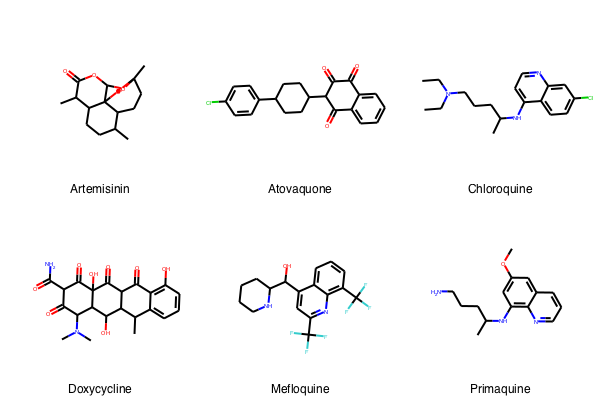

In [108]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in drugs], 
                          legends=drug_labels)

In [109]:
# OK - so no famous malaria drugs are part of the GSK dataset... that's super helpful...
df.loc[df['SMILESIS'].isin(drugs)].shape

(15, 24)

In [116]:
df_labels = ['COMPOUND_ID', 'SYNONYMS', 'pXC50_3D7', 'SMILESIS', 'SMILES']

In [117]:
df.loc[df['SMILESIS'].isin(drugs)][df_labels]

,COMPOUND_ID,SYNONYMS,pXC50_3D7,SMILESIS,SMILES
1776,270724,"Aralen, Chloroquine phosphate, Chloroquine dip...",6.75035,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,CCN(CC)CCCC(C)Nc1ccnc2c1ccc(c2)Cl.OP(=O)(O)O
4319,6579,"Chlorochine, Aralen, Chloroquine",NaN,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,CCN(CC)CCCC(C)Nc1ccnc2c1ccc(c2)Cl
4901,543172,NaN,NaN,OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1,c1cc2c(cc(nc2c(c1)C(F)(F)F)C(F)(F)F)C(C3CCCCN3)O
7454,90635,NaN,NaN,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,CCN(CC)CCCC(C)Nc1ccnc2c1ccc(c2)Cl.OP(=O)(O)O.O...
9408,10388,NaN,NaN,COc1cc(NC(C)CCCN)c2ncccc2c1,CC(CCCN)Nc1cc(cc2c1nccc2)OC.OP(=O)([O-])[O-].O...
9577,51162,NaN,NaN,OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1,c1cc2c(cc(nc2c(c1)C(F)(F)F)C(F)(F)F)C(C3CCCCN3)O
10157,126569,NaN,NaN,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,CCN(CC)CCCC(C)Nc1ccnc2c1ccc(c2)Cl.[O-]P(=O)([O...
12383,543171,NaN,7.16003,OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1,c1cc2c(cc(nc2c(c1)C(F)(F)F)C(F)(F)F)C(C3CCCCN3...
12455,543173,NaN,NaN,OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1,c1cc2c(cc(nc2c(c1)C(F)(F)F)C(F)(F)F)C(C3CCCCN3)O
15787,10389,Primaquine,NaN,COc1cc(NC(C)CCCN)c2ncccc2c1,CC(CCCN)Nc1cc(cc2c1nccc2)OC


In [393]:
df_labels2 = ['COMPOUND_ID', 'SOURCES', 'PCT_INHIB_3D7_PFLDH', 'PCT_INHIB_HEPG2']

In [394]:
df.loc[df['SMILESIS'].isin(drugs)][df_labels2]

,COMPOUND_ID,SOURCES,PCT_INHIB_3D7_PFLDH,PCT_INHIB_HEPG2
1776,270724,"TCMDC-123988, 370724 (CHEMBL), COMMERCIAL",0.0,12.0
4319,6579,106579 (CHEMBL),NaN,NaN
4901,543172,643172 (CHEMBL),NaN,NaN
7454,90635,190635 (CHEMBL),NaN,NaN
9408,10388,110388 (CHEMBL),NaN,NaN
9577,51162,151162 (CHEMBL),NaN,NaN
10157,126569,226569 (CHEMBL),NaN,NaN
12383,543171,"TCMDC-124288, 643171 (CHEMBL)",0.0,0.0
12455,543173,643173 (CHEMBL),NaN,NaN
15787,10389,110389 (CHEMBL),NaN,NaN


In [118]:
df.shape

(26784, 24)

In [119]:
len(df.pXC50_3D7.values[good])

13403

In [120]:
np.unique(df.loc[df['SMILESIS'].isin(drugs)].SMILESIS.values).shape

(5,)

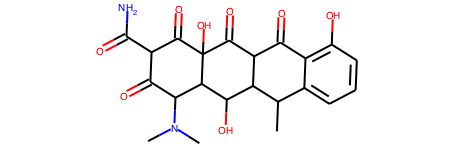

In [126]:
# OK - so Doxycycline is missing from the GSK dataset entirely...
Chem.MolFromSmiles(list(set(drugs).difference(set(df.loc[df['SMILESIS'].isin(drugs)].SMILESIS.values)))[0])

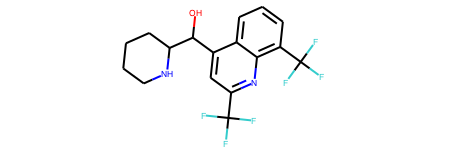

In [127]:
# Also - we have two different (thankfully close values) for Mefloquine
Chem.MolFromSmiles('OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1')

QUESTION:  How does Mefloquine appear twice in the dataset, with VERY different (0, 29%) toxicity values?

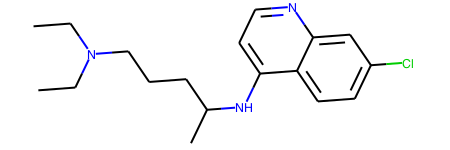

In [128]:
# So then we have a datapoint for chloroquine
Chem.MolFromSmiles('CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12')

OK - so the only data we have is on Chloroquine and Mefloquine.  I guess there are two ways of looking at this - one, this dataset isn't great.  Two - at least we get to predict on some known values!

Let's check also how many unique smiles there are in the Chembl data.

In [133]:
np.unique(df.SMILESIS.values[good])

array(['Brc1cc(Br)c2c(c1)C(NCCCNC1CCNc3c(Br)cc(Br)cc31)CCN2',
       'Brc1cc(Br)c2c(c1)C(NCCCNc1nc3ncccc3[nH]1)CCN2',
       'Brc1cc(CNCCCNc2nc3ccccc3[nH]2)sc1Br', ...,
       'c1csc(-c2nc(NCC3CCCO3)ncc2-c2ccsc2)n1',
       'c1nc(CCNc2nc(Nc3ccc4c(c3)OCO4)nc(NC3CCCC3)n2)c[nH]1',
       'c1nc2nc3c(c(Nc4ccc5c(c4)CCC5)n2n1)CCC3'], dtype=object)

In [134]:
len(np.unique(df.SMILESIS.values[good]))

13327

In [135]:
len(df.SMILESIS.values[good])

13403

#### Looking at potency + toxicity on data...

Unfortunately - and this is a big failing of this first paper (which we'll attempt to remedy in the second) - this dataset only reports stuff that actually worked... (5.7+)

Most stuff isn't that toxic though...

#### Hashed vs non-hashed fingerprints

In [151]:
hfps = [get_fp(x, hashed=True) for x in df.SMILESIS.values]
df['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=df.index)
df.to_pickle('parsed/chembl_all_pkl')

In [391]:
def run_suite(v, typ='df', adjust=None, label=None, add_pred=None):
    
    if typ == 'df':
        print("Analyzing", v)
        pd = df[v].values
    elif typ == 'prec':  # precalculated
        print("Analyzing", label)
        pd = v
    else:
        raise ValueError
    
    gd = ~np.isnan(pd)
    if adjust is not None:
        gd = gd & ~np.isnan(adjust)
        pass
    
    if add_pred is not None:
        gd = gd & ~np.isnan(add_pred.sum(axis=1))
        pass
    
    adj = None if adjust is None else adjust[gd]
    
    for m in ['ridge', 'rf']:
        pred = np.asarray([x for x in df.fps[gd]])
        if add_pred is not None:
            pred = np.hstack((pred, add_pred[gd]))
        full_bootstrap(pred, np.asarray(pd[gd]), m, adjust=adj)
    print ('\nHashed...')
    for m in ['ridge', 'rf']:
        pred = np.asarray([x for x in df.hfps[gd]])
        if add_pred is not None:
            pred = np.hstack((pred, add_pred[gd]))
        full_bootstrap(pred, np.asarray(pd[gd]), m, adjust=adj)
    print('\n')
    
def full_bootstrap(preds, resps, method, num_runs=40, adjust=None):

    r_2s = []
    betas = []

    N = len(resps)
    for i in range(num_runs):
        idcs = np.random.choice(N, N)
        oos = np.delete(np.arange(N), idcs)
        
        mdl = model_dict[method]['m'](**model_dict[method]['kw'])
        mdl.fit(preds[idcs], resps[idcs])
        if adjust is None:
            beta, r2 = regress(resps[oos], [mdl.predict(preds[oos]),], do_print=False, one=False)
        else:
            beta, r2 = regress(resps[oos] + adjust[oos], 
                               [mdl.predict(preds[oos]) + adjust[oos],], do_print=False, one=False)
        if beta < 0:
            r2 *= -1
            pass
        r_2s.append(r2)
        betas.append(beta)
        pass
    
    r_2s = np.asarray(r_2s)
    betas = np.asarray(betas)
    
    print ('Beta:         %9.3f [%8.3f %8.3f] %s' % 
           (np.mean(betas), np.percentile(betas, 5), np.percentile(betas, 95), method))
    print ('R2 (signed):  %9.3f [%8.3f %8.3f] at 5pct conf' % 
           (np.mean(r_2s), np.percentile(r_2s, 5), np.percentile(r_2s, 95)))
    
    

In [164]:
for v in ['PCT_IHB_3D7', 'PCT_INHB_DD2', 'PCT_INHIB_3D7_PFLDH', 'PCT_INHIB_HEPG2', 'IFI', 'pXC50_3D7']:
    run_suite(v)

('Analyzing', 'PCT_IHB_3D7')
Beta:             1.000 [   0.998    1.001] ridge
R2 (signed):      0.063 [   0.050    0.072] at 5pct conf
Beta:             1.001 [   1.000    1.002] rf
R2 (signed):      0.131 [   0.122    0.141] at 5pct conf

Hashed...
Beta:             1.000 [   0.999    1.001] ridge
R2 (signed):      0.069 [   0.060    0.078] at 5pct conf
Beta:             1.000 [   0.998    1.001] rf
R2 (signed):      0.113 [   0.105    0.123] at 5pct conf


('Analyzing', 'PCT_INHB_DD2')
Beta:             0.995 [   0.978    1.013] ridge
R2 (signed):      0.112 [   0.102    0.123] at 5pct conf
Beta:             1.017 [   1.005    1.030] rf
R2 (signed):      0.250 [   0.237    0.262] at 5pct conf

Hashed...
Beta:             0.998 [   0.983    1.011] ridge
R2 (signed):      0.136 [   0.127    0.151] at 5pct conf
Beta:             1.016 [   1.002    1.031] rf
R2 (signed):      0.258 [   0.240    0.274] at 5pct conf


('Analyzing', 'PCT_INHIB_3D7_PFLDH')
Beta:             0.959 [   0.925 

### 3.2.  Lipophilicity
- Two ways of doing prediction
- Comparison with potency
- Using Lipophylicity and potency to cluster.

#### 3.2.0. Intro.

There is this thing called Lipophilicity.  It may matter.  
https://www.ncbi.nlm.nih.gov/pubmed/22823020.
https://www.ncbi.nlm.nih.gov/pubmed/22992175

Layman's introduction:
https://www.sciencedirect.com/topics/pharmacology-toxicology-and-pharmaceutical-science/lipophilicity

So the idea is that your target is really not pIC50 but rather pIC50 - AlogP  (or some model like AlogP that measures lipophilicity).


#### 3.2.1.  Quick look at the data...

We have AlogP in our chembl data - so lets look at our data just to see how correlated AlogP and potency (against 3D7 in any case) are...

In [167]:
%pylab inline
figsize(20, 10)

Populating the interactive namespace from numpy and matplotlib


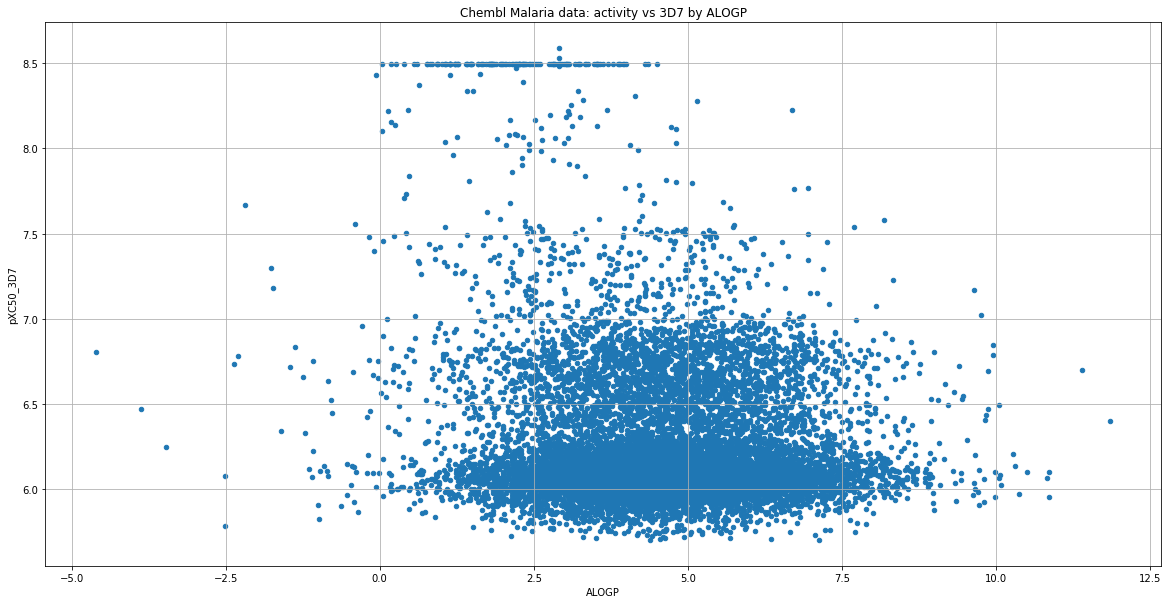

In [170]:
#  No obvious relationship...
df.plot.scatter('ALOGP', 'pXC50_3D7',  grid=True, title='Chembl Malaria data: activity vs 3D7 by ALOGP')


#### 3.2.2.  Two ways of doing prediction.

This is a (reasonably) brief aside - looking at how much better the 'right' way of doing things is from the lazy way (we'll apply this later).

AlogP can (in general) be calculated from a molecule.  Therefore AlogP is not unknown (unlike potency).  We don't have AlogP for our data from Molport - but we can calculate it (a related quantity - just a different model) from the Crippen function from rdkit.  We'll actually go with Crippen since we can generalize to our unknown data...

In [171]:
from rdkit.Chem import Crippen
def get_crippen(x):
    try:
        cp = Crippen.MolLogP(x)
    except:
        return np.nan
    return cp

In [182]:
gd = ~np.isnan(df.crippen.values) & ~np.isnan(df.ALOGP.values)

In [187]:
regress(df.crippen.values[gd], df.ALOGP.values[gd][None,:])

Coeffs:       1.0630 
R-squared:    0.8220


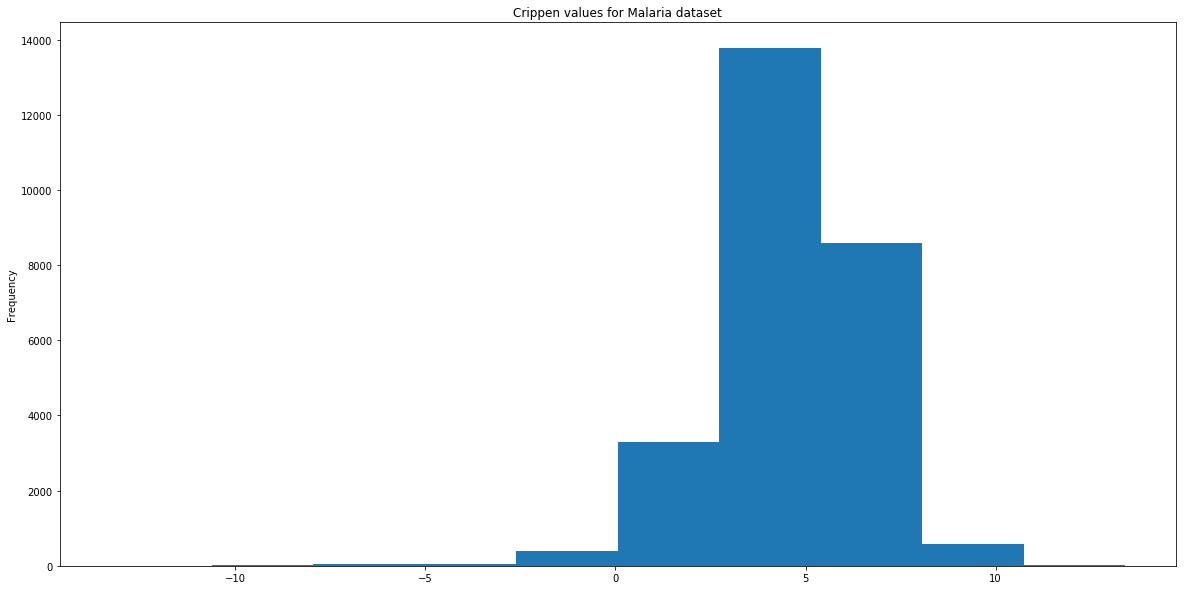

In [189]:
df.crippen.plot.hist(title='Crippen values for Malaria dataset')

Now let's look at the Crippen values for our drugs...

In [200]:
dlc = [str(x[0]) + ': ' + str(x[1]) for x in \
 zip(drug_labels, ['%.2f' % get_crippen(Chem.MolFromSmiles(x)) for x in drugs])]

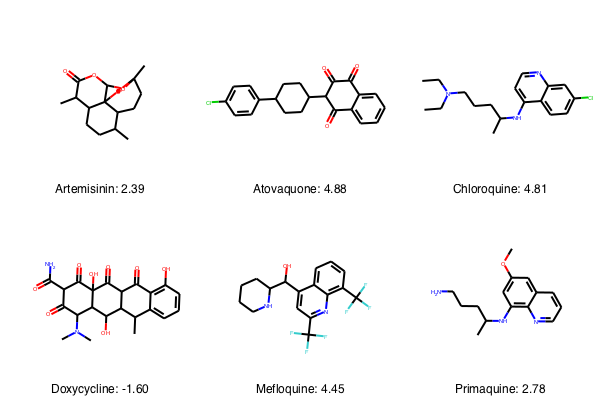

In [201]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in drugs], 
                          legends=dlc)

Ok - so apart from Doxycycline - our drugs don't have super abnormal values of logP (vs the general population of data).   Looking at this - I'd be surprised if 'potency - logP' was really our objective - it looks more like 'Potency as long as log P is in lower half of the data...'

Now we're going to look at the following questions...
1) Is the raw variable 'Potency - logp' more or less predictable than just potency (using an ML model).
2) How about if you do it the correct way (i.e. you predict Potency, and then you calculate logp?

#### A) Just potency (recall from above).

In [204]:
run_suite('pXC50_3D7')

('Analyzing', 'pXC50_3D7')
Beta:             1.000 [   0.998    1.002] ridge
R2 (signed):      0.185 [   0.160    0.215] at 5pct conf
Beta:             0.998 [   0.997    0.999] rf
R2 (signed):      0.430 [   0.398    0.455] at 5pct conf

Hashed...
Beta:             1.000 [   0.999    1.001] ridge
R2 (signed):      0.175 [   0.150    0.202] at 5pct conf
Beta:             1.000 [   0.998    1.001] rf
R2 (signed):      0.416 [   0.377    0.446] at 5pct conf




#### B) potency - logP (the wrong way)

In [206]:
pMlp = df.pXC50_3D7.values - df.crippen.values
run_suite(pMlp, typ='prec', label='Potency - logP (bad way)')

('Analyzing', 'Potency - logP (bad way)')
Beta:             0.988 [   0.962    1.013] ridge
R2 (signed):      0.416 [   0.398    0.431] at 5pct conf
Beta:             1.096 [   1.068    1.122] rf
R2 (signed):      0.562 [   0.547    0.586] at 5pct conf

Hashed...
Beta:             0.994 [   0.976    1.013] ridge
R2 (signed):      0.704 [   0.684    0.717] at 5pct conf
Beta:             1.047 [   1.020    1.070] rf
R2 (signed):      0.672 [   0.657    0.686] at 5pct conf




#### C) Potency - logP (the right way)

In [211]:
run_suite('pXC50_3D7', label='Potency - logP (correct way)', adjust=-df.crippen.values)

('Analyzing', 'pXC50_3D7')
Beta:             1.006 [   0.999    1.012] ridge
R2 (signed):      0.951 [   0.950    0.953] at 5pct conf
Beta:             0.997 [   0.993    1.002] rf
R2 (signed):      0.966 [   0.964    0.968] at 5pct conf

Hashed...
Beta:             1.004 [   0.998    1.011] ridge
R2 (signed):      0.951 [   0.949    0.952] at 5pct conf
Beta:             1.002 [   0.994    1.007] rf
R2 (signed):      0.965 [   0.964    0.967] at 5pct conf




### Using lipophilicity and potency to cluster...

The motivation for our first two papers - and in part for this one - is the following question.  How can we construct 'real' out-of-samples for our QSAR models?  We have looked at using potency in earlier papers - but even here there are biases.  Time doesn't seem to work that well either (in part because the data is so dirty). The challenge is that - in 128-D space - most points are outliers. What about logP?  

To answer the question - 'how well does variable X do in separating space' we will look at the following information.  We split our set of molecular data by quintiles of 'variable X' and compare mean (randomly assessed) Tanimoto distance between points in different quintiles.  

In [217]:
from scipy.spatial.distance import squareform, pdist

In [252]:
def binner(df, bin_label, sample_size=900, num_bins=5):
    
    bin_dict = {'dist_bin' : [], 'mean' : [], 'stdr' : [], 'count' : []}

    dfr = df[df[bin_label].notnull()]
    dfr = dfr[dfr.fps.notnull()]
    N = dfr.shape[0]
    
    bin_size = (N/num_bins)
    
    bin_buckets = (np.argsort(np.argsort(dfr[bin_label].values)) / bin_size).astype(int)
    
    sample = np.random.choice(N, size=sample_size, replace=False)
    
    # How many bins away are they?
    bin_dist = pdist(bin_buckets[sample, None], 'minkowski', 1)
    
    # Tanimoto distance on same sample
    t_dist = pdist(np.asarray([df.fps.values[x] for x in sample]), 'jaccard')
    
    for i in range(num_bins):
        vals = t_dist[bin_dist == i]
        # can be caused by a few bad fingerprints
        vals = vals[~np.isnan(vals)]
        bin_dict['dist_bin'].append(i)
        bin_dict['mean'].append(np.mean(vals))
        ct = len(vals)
        bin_dict['stdr'].append(np.std(vals)/np.sqrt(ct))
        bin_dict['count'].append(ct)
        pass
    
    return pd.DataFrame.from_dict(bin_dict)

In [257]:
binner(df, 'crippen')

,count,dist_bin,mean,stdr
0,80765,0,0.719505,0.000277
1,130633,1,0.717962,0.000217
2,98560,2,0.718809,0.000243
3,63218,3,0.723017,0.000308
4,31374,4,0.727312,0.000424


In [258]:
binner(df, 'pXC50_3D7')

,count,dist_bin,mean,stdr
0,80678,0,0.714937,0.000266
1,130284,1,0.714645,0.000211
2,95978,2,0.714740,0.000246
3,65975,3,0.715406,0.000297
4,31635,4,0.714744,0.000420


In [261]:
#  And - just for fun - we'll bin by toxicity...
binner(df, 'PCT_INHIB_HEPG2')

,count,dist_bin,mean,stdr
0,80861,0,0.714097,0.000277
1,132132,1,0.714417,0.000219
2,98644,2,0.714853,0.000252
3,63310,3,0.712797,0.000309
4,29600,4,0.710869,0.000440


In [290]:
cpb = binner(df, 'crippen', num_bins=10)

In [291]:
cpb.index.name = 'Difference in deciles of predictor'
cpb['mean'].name = 'Bucketed by logP'

In [292]:
ppb = binner(df, 'pXC50_3D7', num_bins=10)
ppb['mean'].name = 'Bucketed by potency'

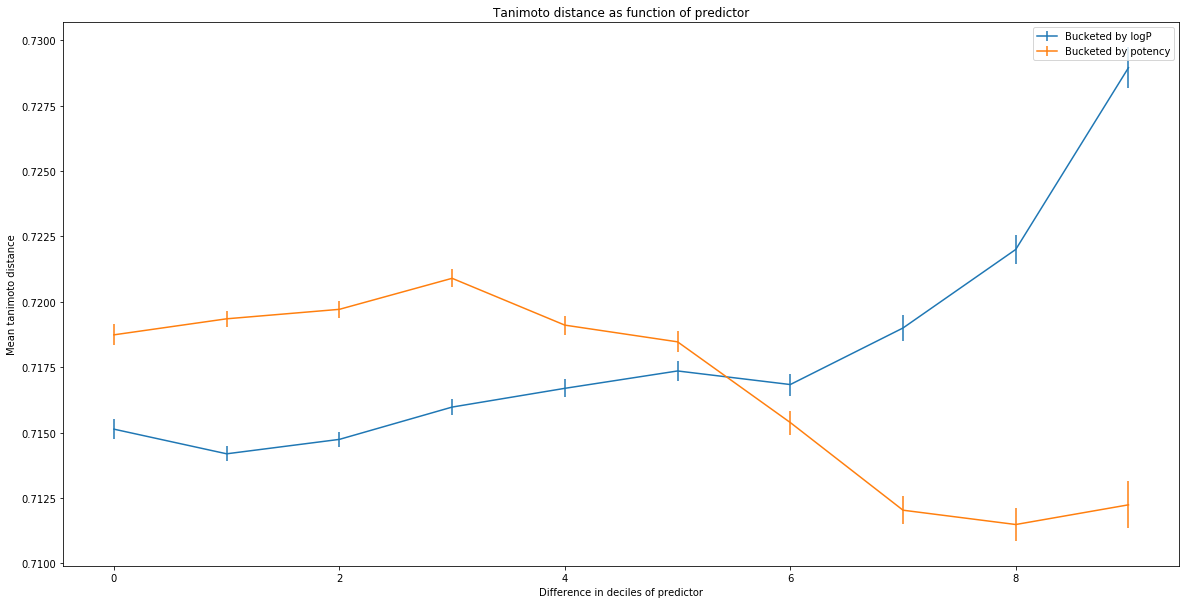

In [293]:
ax = cpb['mean'].plot(yerr=cpb.stdr, title='Tanimoto distance as function of predictor')
ax.set(ylabel='Mean tanimoto distance')
ax2 = ppb['mean'].plot(yerr=ppb.stdr)
plt.legend(loc='best')
plt.show()

### 3.3. The challenge of large datasets.
- Intro: fitting models on large datasets.
- Sensitivity to subsample size.
- Sensitivity to number of estimators.
- Quantile bootstrap results: binning on potency.
- Quantile bootstrap results: binning on Lipophylicity.
- Sensitivity to 'default potency'.

#### 3.3.0.  Fitting models on large datasets..


TODO - implement bag of little bootstraps...

In [295]:

def regress(response, pred_list, one=False, do_print=True):

    regr = LM.LinearRegression(fit_intercept=one)
    regr.fit(np.asarray(pred_list).swapaxes(0, 1), response)
    
    presp = regr.predict(np.asarray(pred_list).swapaxes(0, 1))
    r2 = r2_score(response, presp)
    if do_print:
        if one:
            rs = ('%6.4f '* (len(pred_list) + 1)) % (tuple(regr.coef_) + (regr.intercept_,))
        else:
            rs = ('%6.4f '* (len(pred_list)) % tuple(regr.coef_))
        print ('Coeffs:       ' + rs)
        print ('R-squared: {:9.4f}'.format(r2))
    else:
        return regr.coef_, r2


def get_is_oos(size, num, ss_size, frac_size, choice_method):
    if choice_method == 'random':
        M = int(size * frac_size)
        ixs = np.arange(size)
        np.random.shuffle(ixs)
        choice_set = ixs[:M]
        oos = np.delete(np.arange(size), choice_set)
        is_sets = [np.random.choice(choice_set, ss_size, replace=False) for i in range(num)]
        return is_sets, oos
    else:
        raise NotImplementedError
        
def get_estimator(preds, resps, method):
    return model_dict[method]['m'](**model_dict[method]['kw']).fit(preds, resps)

def get_oos_fc(estimators, preds):
    return np.mean(np.asarray([est.predict(preds) for est in estimators]), axis=0) 

def evaluate(forecast, response):
    beta, r2 = regress(response, [forecast,], do_print=False, one=False)
    if beta < 0:
        r2 *= -1
        pass
    return beta, r2
    

def sub_bootstrap(preds, resps, method, num_estimators=10, 
                  num_bootstrap=10, subsample_size=50000, 
                  insample_size=0.6, insample_choice='random', info_out=False):
    """
    Rather than fitting model **method** on a boostrap sample of the data (and testing OOS), we do the
    following:
    1) Choose a fixed 'insample' of given size (using some method **insample_choice**)
    2) From that insample fit num_estimators estimators
    3) Take mean estimate on OOS - that's your prediction
    3) Do this whole process num_bootstrap times - take error bars on this estimate.
    """
    
    
    betas = []
    r2s   = []
    
    for i in range(num_bootstrap):
        if info_out:
            print('On bootrap run number {}'.format(i))
            
        is_idx_set, oos_idcs = get_is_oos(resps.shape[0], num_estimators, subsample_size,
                                          frac_size=insample_size, 
                                          choice_method=insample_choice)
    
        estimators = []
        for ixs in is_idx_set:
            estimators.append(get_estimator(preds[ixs], resps[ixs], method))
            pass
    
        oos_fc = get_oos_fc(estimators, preds[oos_idcs])
    
        beta, r2 = evaluate(oos_fc, resps[oos_idcs])
        betas.append(beta)
        r2s.append(r2)
        if info_out:
            print('Beta {} r2 {}'.format(beta, r2))
        pass
    
    r2s = np.asarray(r2s) * 1e4
    betas = np.asarray(betas)
    if info_out:
        print ('Beta:           %9.3f [%8.3f %8.3f] %s' % 
               (np.mean(betas), np.percentile(betas, 5), np.percentile(betas, 95), method))
        print ('R2 (sgnd bps):  %9.3f [%8.3f %8.3f] at 5pct conf' % 
               (np.mean(r2s), np.percentile(r2s, 5), np.percentile(r2s, 95)))
    else:
        return betas, r2s
    

#### 3.3.1.  Sensitivity to subsample size and number of estimators..

There are two ways we can make our estimates better...
- use more models (we use 10 above)
- same number of models with bigger samples (we use 50K above)

Here we examine performance of RF and ridge in both dimensions...

In [294]:
subsample_sizes = [10000, 20000, 500000, 100000]
num_models = [5, 10, 20, 40]

In [297]:
ridge_dict = {'mean' : [], 'lower_5pct' : [], 'upper_5pct' : [], 'ss_size' : [], 'num_models' : []}
for ss in subsample_sizes:
    for nm in num_models:
        betas, r2s =  sub_bootstrap(np.vstack((junk_fps, good_preds)), 
                                    np.concatenate((junk_resp, df.pXC50_3D7.values[good])), 
                                      'ridge', info_out=False,
                                   num_estimators=nm, subsample_size=ss
                                   )
        ridge_dict['mean'].append(np.mean(r2s))
        ridge_dict['lower_5pct'].append(np.percentile(r2s, 5))
        ridge_dict['upper_5pct'].append(np.percentile(r2s, 95))
        ridge_dict['ss_size'].append(ss)
        ridge_dict['num_models'].append(nm)
        pass
    pass

In [301]:
pd.DataFrame.from_dict(ridge_dict)

,lower_5pct,mean,num_models,ss_size,upper_5pct
0,26.597153,35.163561,5,10000,40.757697
1,44.839648,47.447389,10,10000,51.538251
2,52.210291,54.351396,20,10000,57.732908
3,57.158385,58.989675,40,10000,60.807926
4,45.114445,49.050224,5,20000,51.427222
5,52.338074,55.078394,10,20000,57.780574
6,58.019734,59.241558,20,20000,60.793398
7,58.641081,60.728300,40,20000,62.335880
8,59.282359,61.048452,5,500000,62.961037
9,60.325529,61.672265,10,500000,62.670637


#### 3.3.2.  Quantile bootstrap results.

In this section, we'll use the methods in paper [2] as follows.  We'll select 60% of the data:
1) Randomly
2a) Non-randomly - only fit on bottom 60% of potency
2b) Non-randomly - only fit on bottom 60% of logP.


Then we'll look at the placment of top 1%/5%/10% of active malaria data in the OOS...
1) Using ridge
2) Using RF

(We'll look at avg/min rank functions)

We'll compare fitting on everything / fitting just on 'good' - and epsilonic values to each side.  So... All in all:

    2 x Model type  (ridge, rf)
    3 x Active selection type  (random, potency, logP)
    3 x Inactive selection type (nothing, epsilon, everything)
    3 x Target selection type (nothing, epsilon, everything)
    (potentially: 6 x objective functions)

### 4.0 QED

#### 4.1.  QED for our drugs, on Chembl and on Molport...

In [307]:
def get_qed(mol):
    if mol is None:
        return np.nan
    return qed(mol)

df['qed'] = pd.Series([get_qed(Chem.MolFromSmiles(sm)) for sm in df.SMILES.values], index=df.index)

In [321]:
# Molport pickle files - we'll just chose one...
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')

In [322]:
mp1 = pd.read_pickle(std_files[0])

In [331]:
#mp1['qed'] = pd.Series([get_qed(Chem.MolFromSmiles(sm)) for sm in mp1.SMILESIS.values], index=mp1.index)

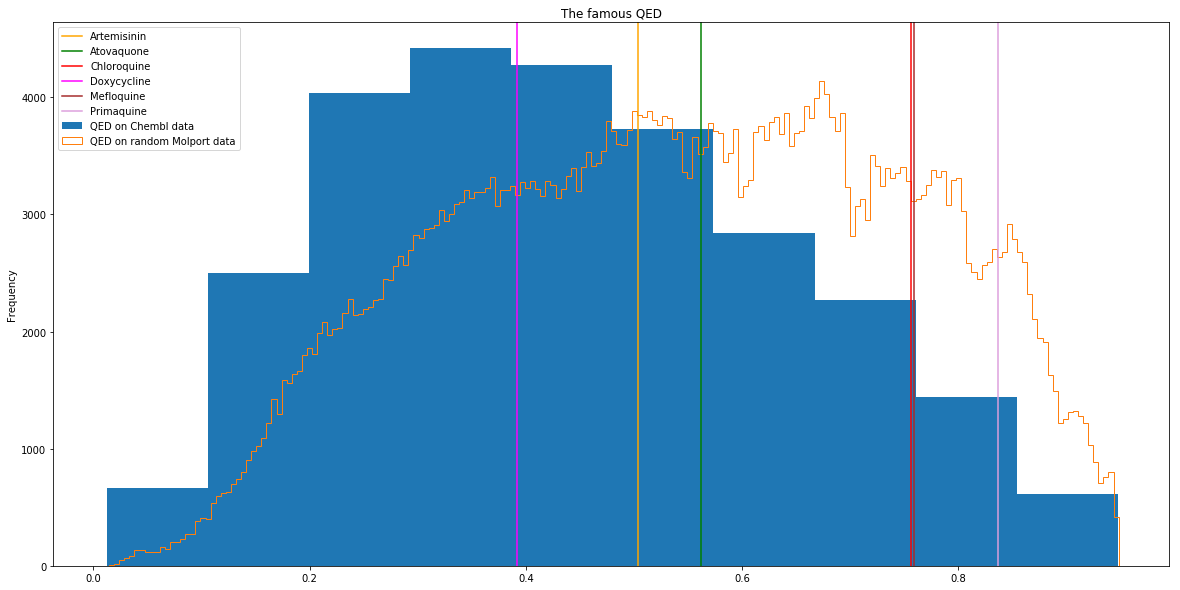

In [330]:
colors = ['orange', 'green', 'red', 'magenta', 'brown', 'plum']
df.qed.plot.hist(title='The famous QED')
df.qed.name = 'QED on Chembl data'
mp1.qed.name = 'QED on random Molport data'
mp1.qed.plot.hist(histtype='step', bins=200)
for i in range(6):
    plt.axvline(x=qed(Chem.MolFromSmiles(drugs[i])), color=colors[i], label=drug_labels[i])
legend()

#### 4.2. Does QED predict potency / potency - logP / toxicity?

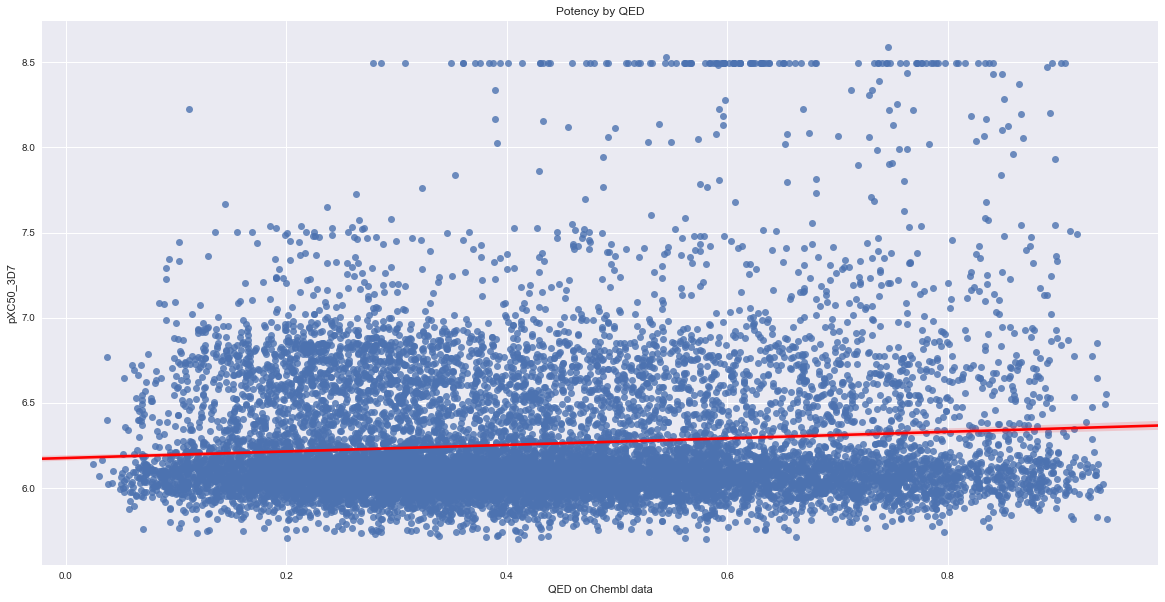

In [359]:
# Not a strong effect on Potency - but it is highly significant...
sns.regplot(x='qed',y='pXC50_3D7',data=df,fit_reg=True, line_kws={'color' : 'red'})
_ = plt.title('Potency by QED')

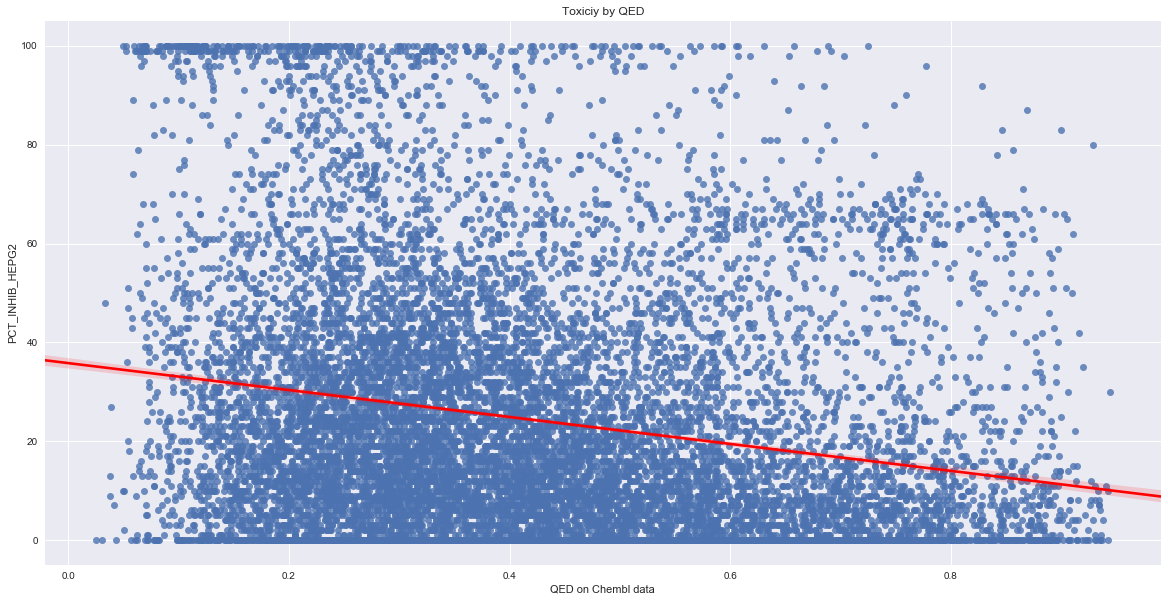

In [402]:
# The effect on toxicity is actually quite impressive...
sns.regplot(x='qed',y='PCT_INHIB_HEPG2',data=df,fit_reg=True, line_kws={'color' : 'red'})
_ = plt.title('Toxiciy by QED')

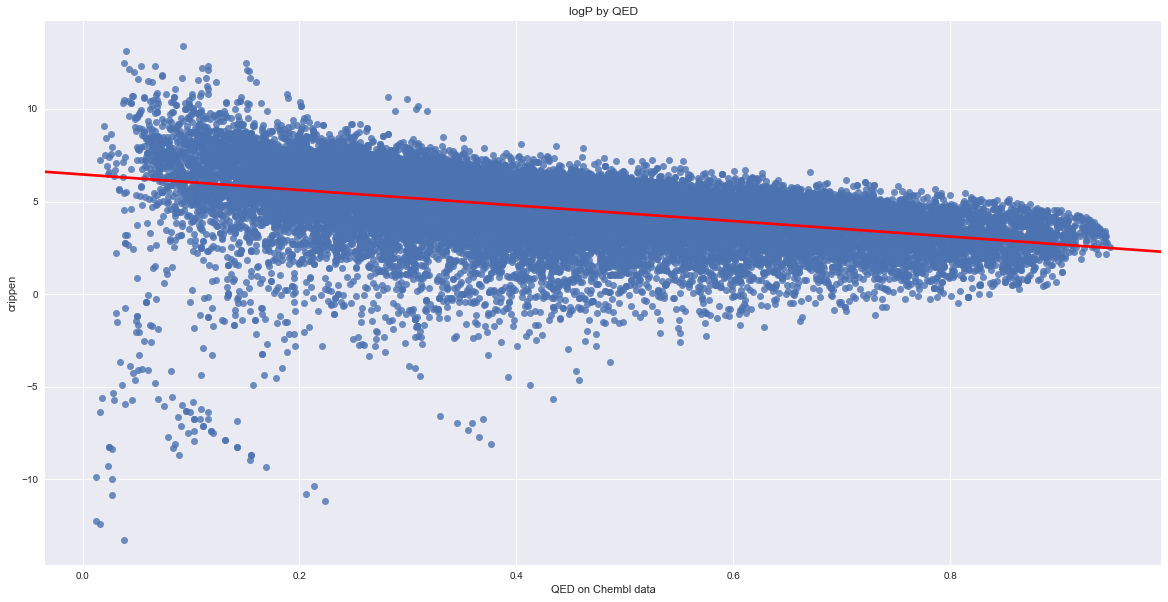

In [363]:
# How related (if at all) is this to logP?
sns.regplot(x='qed',y='crippen',data=df,fit_reg=True, line_kws={'color' : 'red'})
_ = plt.title('logP by QED')

Let's compare the value add (mainly focussed on tox) of QED vs logP...

In [335]:
# Potency vs QED - R2 of 88 bps
gd = ~np.isnan(df.pXC50_3D7.values + df.qed.values)
regress(df.pXC50_3D7.values[gd], [df.qed.values[gd]], one=True)

Coeffs:       0.1925 6.1767 
R-squared:    0.0088


In [361]:
# Tox vs QED - R2 of 4.6%
gd = ~np.isnan(df.PCT_INHIB_HEPG2.values + df.qed.values)
regress(df.PCT_INHIB_HEPG2.values[gd], [df.qed.values[gd]], one=True)

Coeffs:       -27.2512 35.8030 
R-squared:    0.0460


In [364]:
# TOX vs logP - R2 of 5.4%
gd = ~np.isnan(df.PCT_INHIB_HEPG2.values + df.crippen.values)
regress(df.PCT_INHIB_HEPG2.values[gd], [df.crippen.values[gd]], one=True)

Coeffs:       3.8011 5.1452 
R-squared:    0.0547


In [365]:
# Potency vs logP - R2 of almost 2%
gd = ~np.isnan(df.pXC50_3D7.values + df.crippen.values)
regress(df.pXC50_3D7.values[gd], [df.crippen.values[gd]], one=True)

Coeffs:       -0.0367 6.4428 
R-squared:    0.0197


In [366]:
# Tox vs logP and QED... (no value add - we'll ignore QED hencforth)
gd = ~np.isnan(df.PCT_INHIB_HEPG2.values + df.crippen.values + df.qed.values)
regress(df.PCT_INHIB_HEPG2.values[gd], [df.qed.values[gd], df.crippen.values[gd]])

Coeffs:       -0.2179 4.7482 
R-squared:    0.0511


As a final investigation - let's see whether adding logP to our set of fingerprint predictors much increases our benchmark model performance...

In [389]:
%pdb off

Automatic pdb calling has been turned OFF


In [388]:
run_suite('PCT_INHIB_HEPG2')

Analyzing PCT_INHIB_HEPG2
Beta:             0.987 [   0.962    1.016] ridge
R2 (signed):      0.126 [   0.114    0.135] at 5pct conf
Beta:             1.017 [   0.996    1.040] rf
R2 (signed):      0.303 [   0.286    0.316] at 5pct conf

Hashed...
Beta:             0.987 [   0.955    1.013] ridge
R2 (signed):      0.187 [   0.174    0.197] at 5pct conf
Beta:             1.026 [   1.005    1.053] rf
R2 (signed):      0.314 [   0.299    0.329] at 5pct conf




In [392]:
run_suite('PCT_INHIB_HEPG2', add_pred=df.crippen.values[:,None])

Analyzing PCT_INHIB_HEPG2
Beta:             0.984 [   0.960    1.015] ridge
R2 (signed):      0.155 [   0.140    0.171] at 5pct conf
Beta:             1.015 [   0.991    1.034] rf
R2 (signed):      0.331 [   0.317    0.346] at 5pct conf

Hashed...
Beta:             0.987 [   0.964    1.016] ridge
R2 (signed):      0.189 [   0.174    0.207] at 5pct conf
Beta:             1.031 [   1.005    1.055] rf
R2 (signed):      0.334 [   0.315    0.353] at 5pct conf




Yup - Crippen does actually help (almost 2% net increase in R2 on our top model - though now it doesn't make much difference if you use hashed fingerprints - they're slightly better...

### 5.0.  Molport suggestions...

So in this final section - we'll have some fun.
https://www.nature.com/articles/nature09107 

5.0.  Max potency. (plot:  name, price, prediction_rf, prediction_rdg)

5.1.  Max(potency - logP) - using ridge predictors.

5.2.  Max(potency) with Herg < 0.3, log_p < 4, 

In [399]:
# OK... so which models do we need?

# Potency models (rf + ridge)
# tox model (rf + ridge), with logP data added (fit on hashed FPs)

# that's it...

fc_dict = {'tox' : {'base' : 'hfps', 'add' : ['crippen',], 'resp' : 'PCT_INHIB_HEPG2'},
           'power' : {'base' : 'fps', 'add' : [], 'resp' : 'pXC50_3D7' },
           }

def fit_models():
    
    mdls = {}
    
    for mdl_typ in fc_dict.keys():
        mdls[mdl_typ] = {}
        preds_base = df[fc_dict[mdl_typ]['base']]
        resp = df[fc_dict[mdl_typ]['resp']]
        gd = ~np.isnan(resp)
        for pred in fc_dict[mdl_typ]['add']:
            gd = gd & ~ np.isnan(df[pred].values)
            pass
        
        preds = np.asarray([x for x in preds_base.values[gd]])
        
        for pred in fc_dict[mdl_typ]['add']:
            preds = np.hstack((preds, df[pred].values[gd,None]))
            
        for typ in ['rf', 'ridge']:
            mdls[mdl_typ][typ] = model_dict[typ]['m'](**model_dict[typ]['kw']).fit(preds, resp[gd])
            pass
        pass
    
    return mdls

In [400]:
full_models = fit_models()

In [450]:
def get_mp_price(tdf, ix):
    
    v = tdf.PRICERANGE_1MG.values[ix]
    if '-' in v or '<' in v or '>' in v:
        return v + '/1MG'
    v = tdf.PRICERANGE_5MG.values[ix]
    if '-' in v or '<' in v or '>' in v:
        return v + '/5MG'
    v = tdf.PRICERANGE_50MG.values[ix]
    return v + '/50MG'

def get_mp_labels(tdf, idcs, potency, crippen, tox, qed):
    
    mp_labels = {'SMILES' : [], 'LABELS' : [], 'POTENCY' : potency[idcs], 'LOGP' : crippen[idcs]}
    
    for ix in idcs:
        mp_labels['SMILES'].append(tdf.SMILESIS.values[ix])
        
        px = get_mp_price(tdf, ix)
        
        label = 'P={:.2f} log_p={:.2f} tx={:.2f} qed={:.2f} px {}'.format(
            potency[ix], crippen[ix], tox[ix], qed[ix], px)
        
        label = 'P={:.2f} L={:.2f} T={:.2f} Q={:.2f}'.format(
            potency[ix], crippen[ix], tox[ix], qed[ix])
        mp_labels['LABELS'].append(label)
    
    return mp_labels

def get_results(fn, num=10, log_p_thresh=4, tox_thresh=25, qed_thresh=0.5, rf_sc_tx=0.5, rf_sc_pot=0.5):
    """
    - going to return four types of results, keyed by tag.
    
    POT:    (potency) the {num} most potent.
    LIP:    (lipophilicity) the {num} that score highest on potency - logP
    BEST_O: (best Ollie)  the most potent subject to:
           - logP < logPthresh
           - tox < 0.25
    BEST_Q: (best QED) - as above but with QED > 0.5
    """
    
    df1 = pd.read_pickle(fn)
    preds = np.vstack(df1['fps'])
 
    
    if 'crippen' not in df1:
        df1['qed'] = pd.Series([get_qed(Chem.MolFromSmiles(sm)) for sm in df1.SMILESIS.values], index=df1.index)
        df1['crippen'] = pd.Series([get_crippen(Chem.MolFromSmiles(sm)) for sm in df1.SMILESIS.values], 
                                   index=df1.index)
        df1.to_pickle(fn)
        pass
    crippen = df1.crippen.values
    qed = df1.qed.values

    # Potency
    potency = (1-rf_sc_pot) * full_models['power']['ridge'].predict(preds)
    potency  += rf_sc_pot * full_models['power']['rf'].predict(preds)

    gd = ~np.isnan(crippen)
    tox = 100 * np.ones_like(potency)

    
    preds = np.asarray([x for x in df1['hfps'].values[gd]])
    preds = np.hstack((preds, crippen[gd,None]))

    tox[gd] = (1-rf_sc_tx) * full_models['tox']['ridge'].predict(preds)
    tox[gd] += rf_sc_tx * full_models['tox']['rf'].predict(preds)
    
    # highest potency...
    best_pot = np.argsort(-potency)[:num]

    lip = potency - crippen
    lip[np.isnan(lip)] = -100
    
    best_lip = np.argsort(-lip)[:num]
    
    # best ollie
    ollie = potency.copy()
    ollie[np.isnan(crippen)] = 0
    ollie[crippen > log_p_thresh] = 0
    ollie[np.isnan(tox)] = 0
    ollie[tox > tox_thresh] = 0
    
    best_ollie = np.argsort(-ollie)[:num]

    ollie[qed < 0.5] = 0
    best_ollie_q = np.argsort(-ollie)[:num]
    
    return {'POT' : get_mp_labels(df1, best_pot, potency, crippen, tox, qed),
            'LIP' : get_mp_labels(df1, best_lip, potency, crippen, tox, qed),
            'BEST_O' : get_mp_labels(df1, best_ollie, potency, crippen, tox, qed),
            'BEST_Q' : get_mp_labels(df1, best_ollie_q, potency, crippen, tox, qed)}

In [454]:
def get_best(num=50):
    hdr = []
    count = 0
    for fn in std_files:
        count += 1
        print(count)
        hdr.append(get_results(fn))
        pass
    joblib.dump(hdr, 'molport_best')

In [456]:
#get_best()

In [457]:
best = joblib.load('molport_best')

In [469]:
def summarize(typ='POT', num=20):
    
    smiles = []
    labels = []
    values = []
    
    best = joblib.load('molport_best')
    for b in best:
        smiles += list(b[typ]['SMILES'])
        labels += list(b[typ]['LABELS'])
        pot = list(b[typ]['POTENCY'])
        if typ == 'LIP':
            logp = b[typ]['LOGP']
            for (i, p) in enumerate(pot):
                values.append(p-logp[i])
            pass
        else:
            values += pot
        pass
    
    idcs = np.argsort(-1*np.asarray(values))[:num]
    return Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smiles[x]) for x in idcs], 
                          legends=[labels[x] for x in idcs])

### BEST ON POTENCY

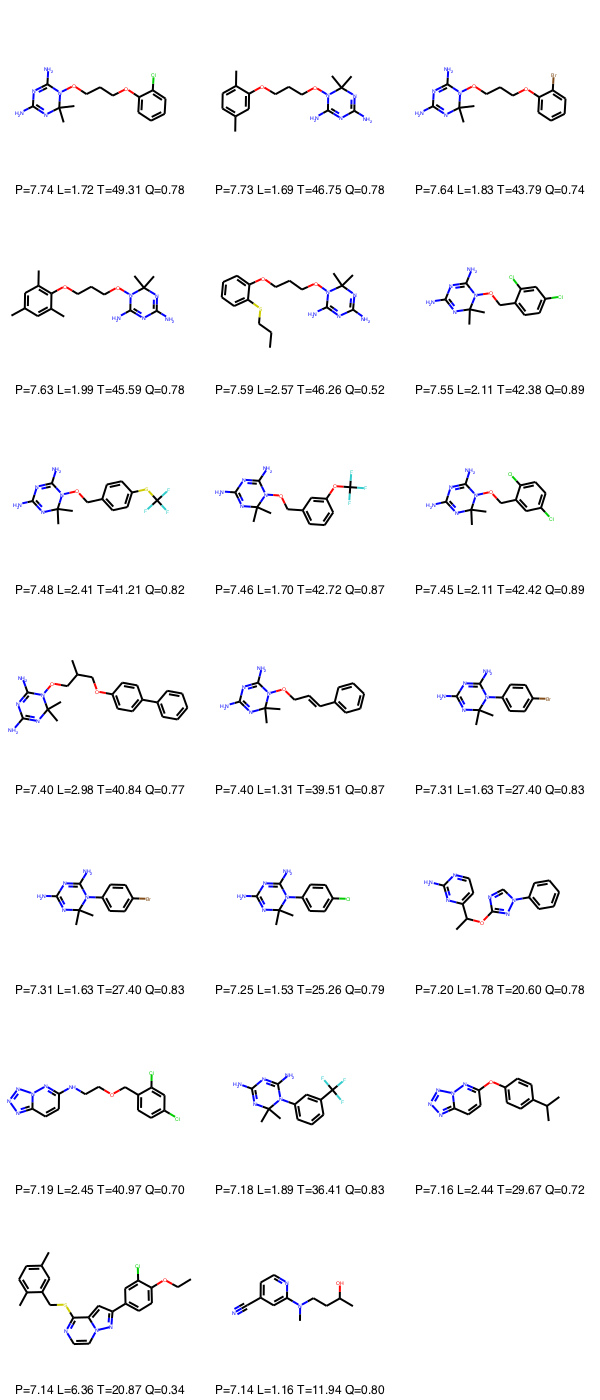

In [465]:
summarize()

### BEST on Potency - LogP

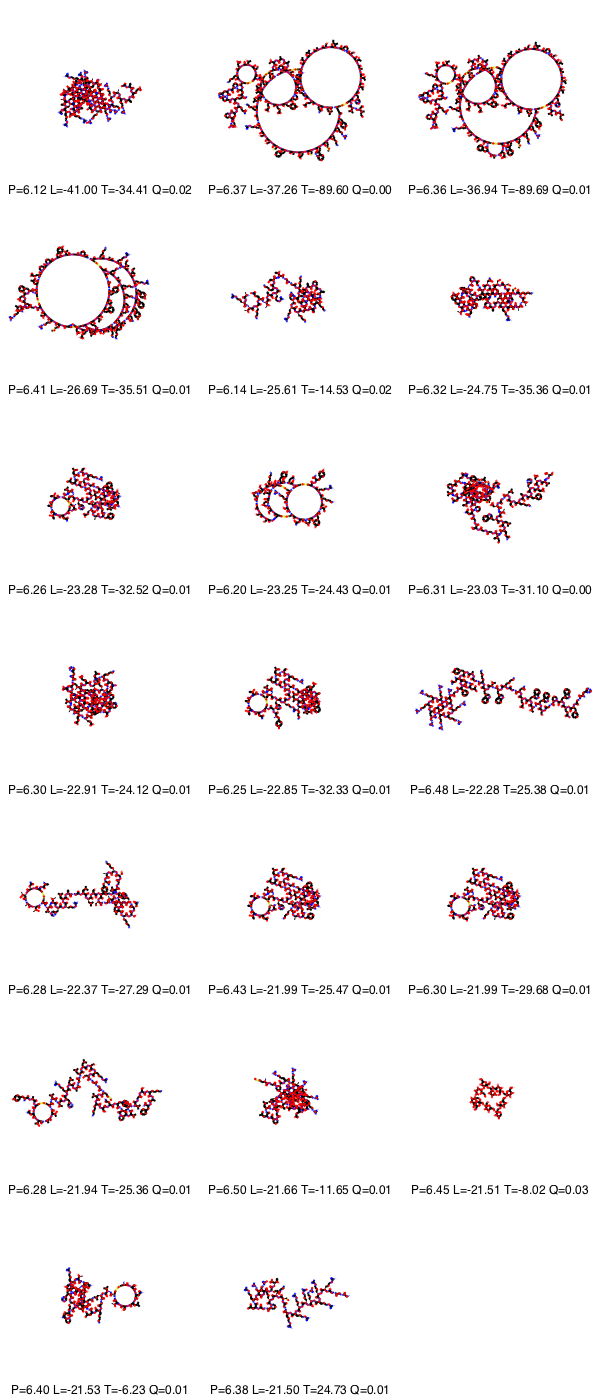

In [470]:
summarize(typ='LIP')

### Best on Potency - with logP and Tox thresholds

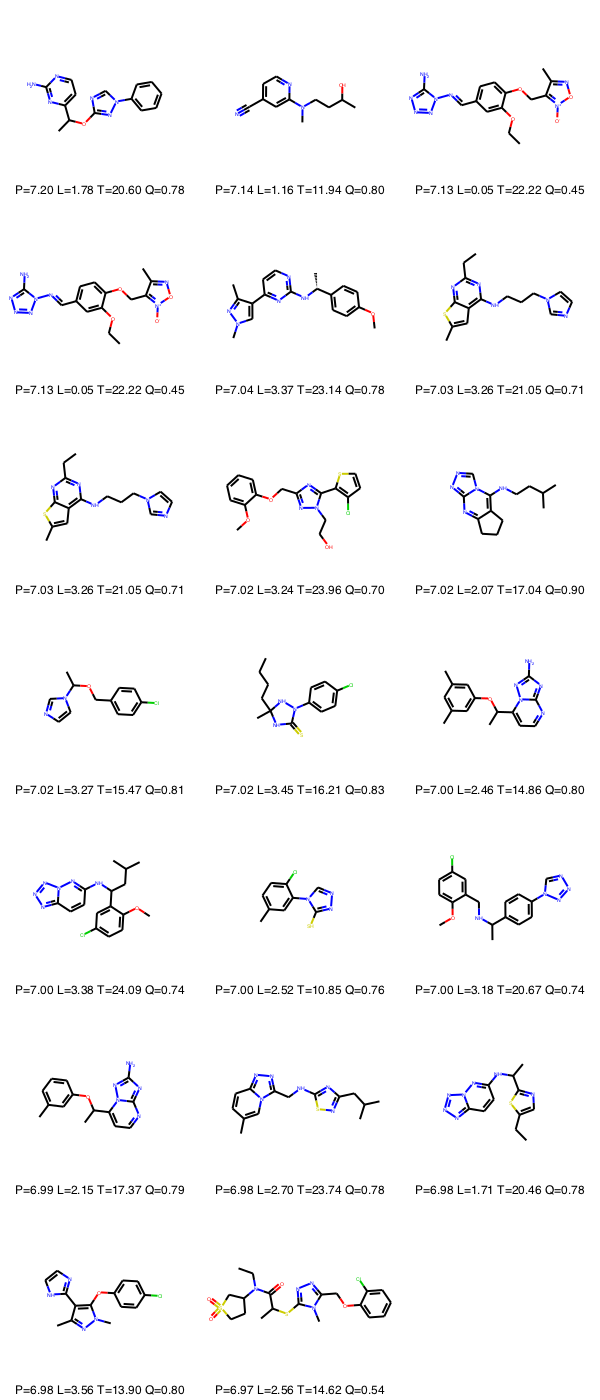

In [471]:
summarize(typ='BEST_O')

### Best on Potency - with logP, tox and QED thresholds

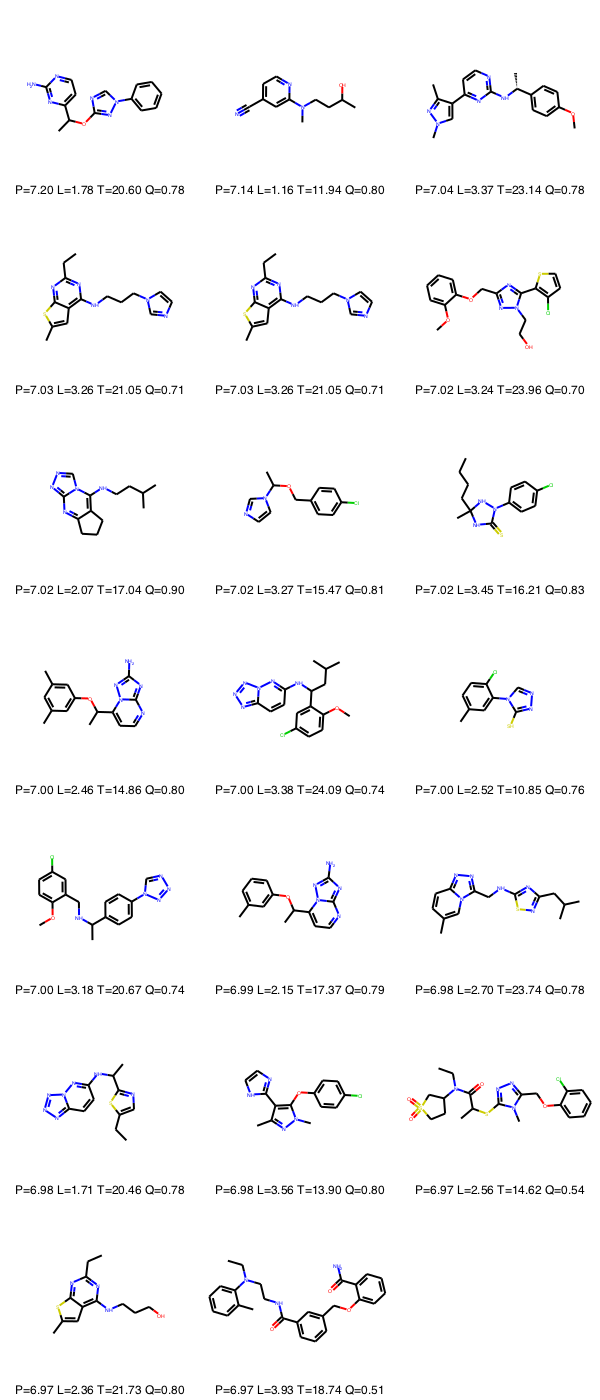

In [472]:
summarize('BEST_Q')

### Final fun investiation - what do our predictions look like for the _actual_ drugs?

In [475]:
drug_fps = [get_fp(d) for d in drugs]
drug_hfps = [get_fp(d, hashed=True) for d in drugs]

In [477]:
np.vstack(drug_fps).shape

(6, 128)

In [481]:
drug_crippen = [get_crippen(Chem.MolFromSmiles(d)) for d in drugs]

In [482]:
drug_crippen

[2.3949000000000007,
 4.878300000000004,
 4.810600000000004,
 -1.6011999999999977,
 4.447900000000003,
 2.782700000000001]

In [485]:
tox_preds = np.hstack((drug_hfps, np.asarray(drug_crippen)[:,None]))

In [507]:
ridge_pot = full_models['power']['ridge'].predict(np.vstack(drug_fps))
rf_pot = full_models['power']['rf'].predict(np.vstack(drug_fps))
ridge_tox = full_models['tox']['ridge'].predict(tox_preds)
rf_tox = full_models['tox']['rf'].predict(tox_preds)

In [512]:
ddict ={'Names' : drug_labels, 
        'Tox_rf' : rf_tox,
        'Tox_rdg' : ridge_tox, 
        'pot_rf' : rf_pot,
        'pot_rdg' : ridge_pot,         
        'In data' : ['N', 'N', 'Y', 'N', 'Y', 'N']
       }

In [513]:
pd.DataFrame.from_dict(ddict)

,In data,Names,Tox_rdg,Tox_rf,pot_rdg,pot_rf
0,N,Artemisinin,6.417339,13.583158,6.558669,6.238537
1,N,Atovaquone,18.342187,16.780357,6.066148,6.228107
2,Y,Chloroquine,16.874455,15.331670,6.535740,6.494176
3,N,Doxycycline,6.482998,15.091425,6.180372,6.209936
4,Y,Mefloquine,7.651097,13.128122,6.350657,6.631006
5,N,Primaquine,9.690116,13.186582,6.251398,6.289080


In [499]:
np.mean(df.pXC50_3D7.values[~np.isnan(df.pXC50_3D7.values)])

6.2577161583227641

In [506]:
np.mean(df.PCT_INHIB_HEPG2.values[~np.isnan(df.PCT_INHIB_HEPG2.values)])

24.379478705025164

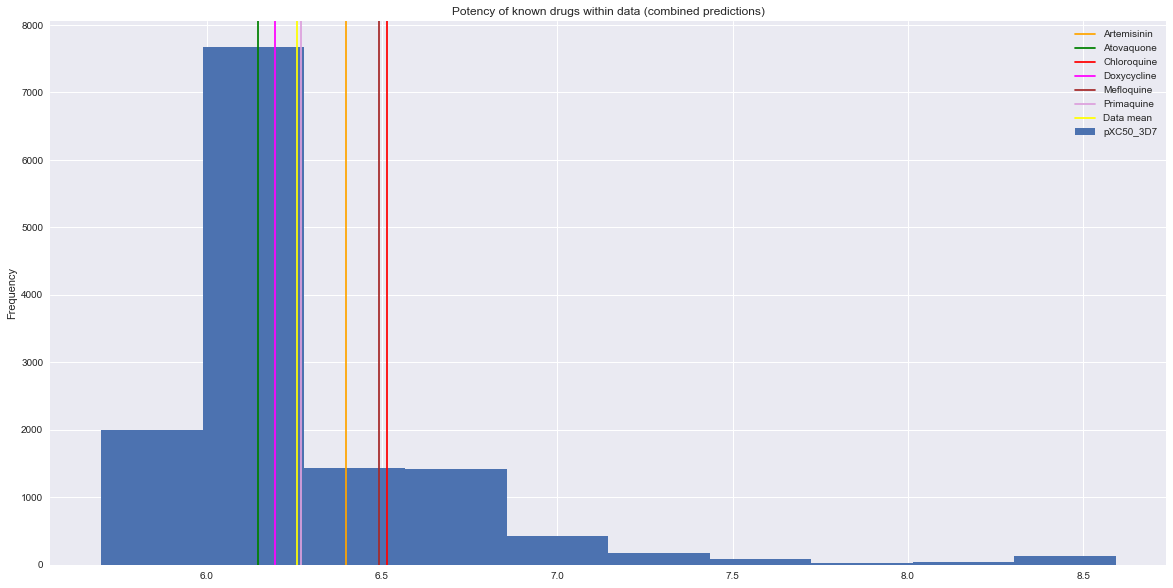

In [505]:
colors = ['orange', 'green', 'red', 'magenta', 'brown', 'plum']
df.pXC50_3D7.plot.hist(title='Potency of known drugs within data (combined predictions)')
for i in range(6):
    plt.axvline(x=(rf_pot[i]+ridge_pot[i])/2, color=colors[i], label=drug_labels[i])
plt.axvline(x=6.2577, color='yellow', label='Data mean')
legend()

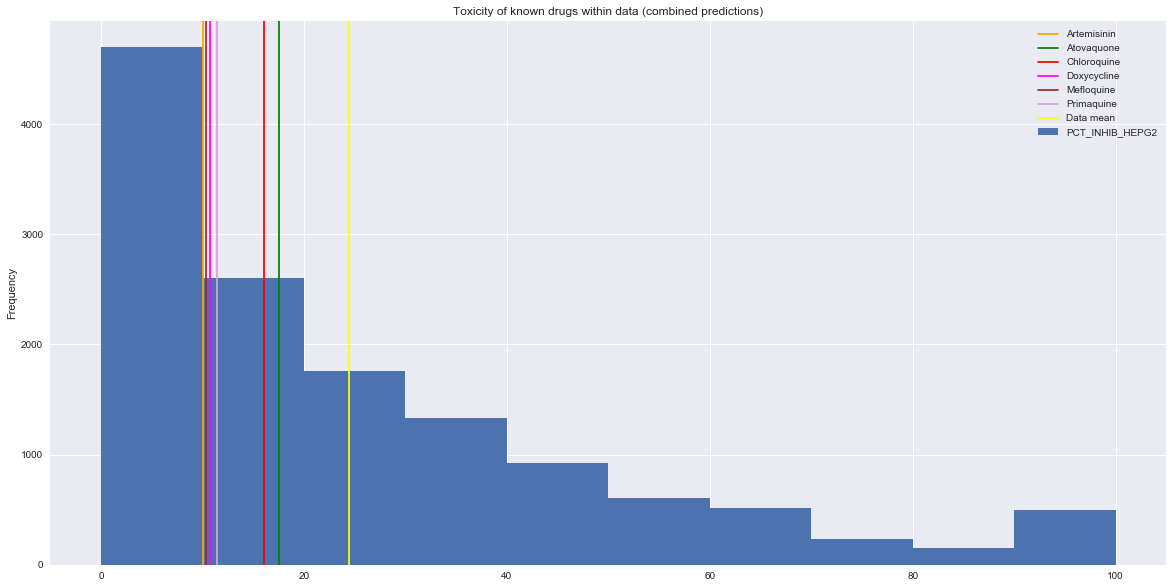

In [510]:
colors = ['orange', 'green', 'red', 'magenta', 'brown', 'plum']
df.PCT_INHIB_HEPG2.plot.hist(title='Toxicity of known drugs within data (combined predictions)')
for i in range(6):
    plt.axvline(x=(rf_tox[i]+ridge_tox[i])/2, color=colors[i], label=drug_labels[i])
plt.axvline(x=24.4, color='yellow', label='Data mean')
legend()